In [1]:
import numpy as np
import sys
sys.path.insert(1, '../../core/')
sys.path.insert(1, '../../')
import networkx as nx
import os
import scipy.sparse as sps
from DataTools import MeasureNetwork
from tqdm import tqdm
from CoarsenTools import parse_dataset, load_data
import torch 
import matplotlib.pyplot as plt

In [26]:
base = '../../'
folder = 'dataset_exp1'
methods = ["Jin_Multi", "Jin_Spectral", "Chen_GW", "Our_Spectral", "Our_Iter"] # ["Jin_Spectral", "Chen_GW", 'Our_Spectral']
datasets = ["MSRC_9"]

sample = load_data(datasets[0], methods[0], base, folder, True)
is_seq = isinstance(sample[0][0], list) or isinstance(sample[0][0], np.ndarray)
seq_len = len(sample[0][0])
num_dists_comp = (len(methods), len(sample[0]), seq_len) if is_seq else (len(methods), len(sample[0]))

In [ ]:
for i, dataset_name in enumerate(datasets):
    A, P, X, _ = load_data(dataset_name, "Original", base, False)
    Ms = [MeasureNetwork(*x) for x in zip(A,P,X)]
    all_dists = torch.zeros(num_dists_comp)

    for j, method_name in enumerate(methods): 
        Ac,Pc,Xc,Q,labels = load_data(dataset_name, method_name, base, folder, True)
        if not is_seq: 
            Mcs = [MeasureNetwork(*x) for x in zip(Ac,Pc,Xc)]
            for k, (m, mc, q) in enumerate(zip(Ms, Mcs, Q)): 
                tran = torch.tensor(q>0, dtype=m.graph.dtype) / q.shape[0] 
                if j == 2: 
                    mc = m.transform(torch.tensor(q>0, dtype=m.graph.dtype)) # to make fairer comparison, compare adjacencies
                assert(torch.abs(1 - torch.sum(tran)) < 1e-4)
                dist = m.distortion(mc, tran)  
                all_dists[j, k] = dist 
        else: #    # graphs in data x # coarsenings per graph
            # print(list(zip(Ac[0], Pc[0], Xc[0])))
            for k in range(len(Ac)):
                Ms_Qs = [[MeasureNetwork(*m) , q] for (m,q) in zip(zip(Ac[k], Pc[k], Xc[k]), Q[k])]
                m = Ms[k]
                for l, (mc, q) in enumerate(Ms_Qs): 
                    q_prime = torch.tensor(q>0, dtype=m.graph.dtype)
                    tran = q_prime / q.shape[0]
                    if j == 2: 
                        mc = m.transform(q_prime) # to make fairer comparison, compare adjacencies
                    assert(torch.abs(1 - torch.sum(tran)) < 1e-4)
                    dist = m.distortion(mc, tran) 
                    all_dists[j,k,l] = dist


/tmp/ipykernel_810010/3803578627.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_prime = torch.tensor(q>0, dtype=m.graph.dtype)


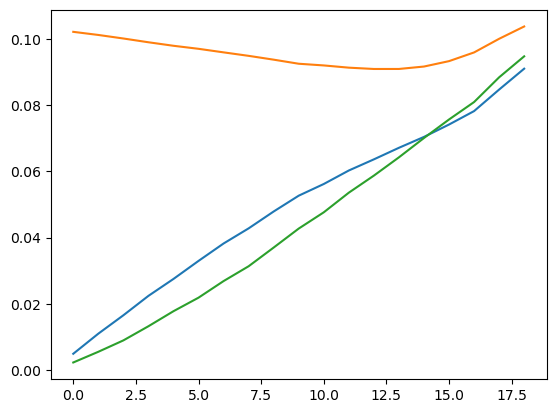

In [17]:
plt.plot(np.mean(all_dists.numpy().T, axis=1))

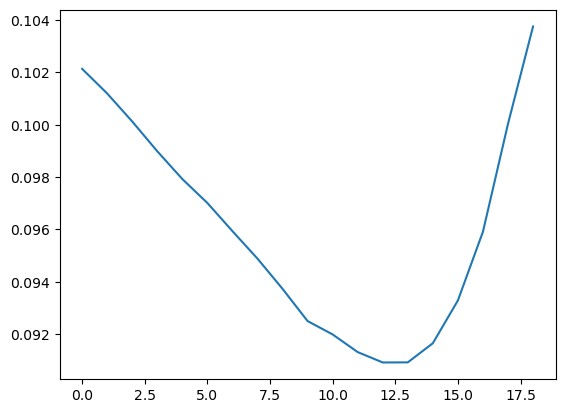

In [ ]:
plt.plot(np.mean(all_dists.numpy()[1,:,:], 0))